✅ 1. Importation et Initialisation

In [0]:
# Importation des bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, avg, when, sum, size, expr, year, to_date, to_timestamp, 
    explode, split, regexp_replace, trim, concat_ws
)
import matplotlib.pyplot as plt
import pandas as pd

# Initialisation de Spark
spark = SparkSession.builder.appName("Steam Analysis").getOrCreate()


✅ 2. Chargement et Nettoyage des Données

In [0]:
# ✅ 2.1 Chargement des données brutes
df = spark.read.json("s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json")

# ✅ 2.2 Sélection des colonnes pertinentes
df = df.select(
    col("data.appid").alias("appid"),
    col("data.categories").alias("categories"),
    col("data.ccu").alias("ccu"),
    col("data.developer").alias("developer"),
    col("data.discount").cast("float").alias("discount"),
    col("data.genre").alias("genre"),
    col("data.header_image").alias("header_image"),
    col("data.initialprice").alias("initialprice"),
    col("data.languages").alias("languages"),
    col("data.name").alias("name"),
    col("data.negative").alias("negative"),
    col("data.owners").alias("owners"),
    col("data.platforms.linux").alias("linux"),
    col("data.platforms.mac").alias("mac"),
    col("data.platforms.windows").alias("windows"),
    col("data.positive").alias("positive"),
    col("data.price").cast("float").alias("price"),
    col("data.publisher").alias("publisher"),
    col("data.release_date").alias("release_date"),
    col("data.required_age").alias("required_age"),
    col("data.short_description").alias("short_description"),
    col("data.tags").alias("tags"),
)

# ✅ 2.3 Extraction de l'année de sortie
df = df.withColumn(
    "release_year",
    year(to_date(to_timestamp("release_date", "yyyy/MM/d"))).cast("int")
)

# ✅ 2.4 Nettoyage des valeurs aberrantes et incohérences
string_columns = ["developer", "genre", "languages", "name", "publisher", "release_date", "required_age", "short_description"]
df = df.replace("", None, subset=string_columns)

df = df.withColumn("categories", when(size(col("categories")) == 0, None).otherwise(col("categories")))

df = df.withColumn("required_age", when(col("required_age") == "180", "18").otherwise(col("required_age")))

df = df.withColumn("release_date", regexp_replace(col("release_date"), r"/(\d{1})$", r"/0\1"))

df = df.withColumn(
    "owners",
    expr(
        """
        CASE 
            WHEN owners LIKE '%..%' 
            THEN (CAST(split(owners, ' .. ')[0] AS INT) + CAST(split(owners, ' .. ')[1] AS INT)) / 2
            ELSE NULL
        END
        """
    )
)

# ✅ 2.5 Transformation de la colonne `tags` en liste
tag_columns = df.select("tags.*").columns
df = df.withColumn("tags", concat_ws(", ", *[col(f"tags.`{tag}`").cast("string") for tag in tag_columns]))

print("✅ Nettoyage terminé, dataset prêt pour analyse !")


✅ Nettoyage terminé, dataset prêt pour analyse !


📊 3.1 Analyse Macro

🔸 1. Éditeurs avec le plus de jeux

        publisher  count
0  Big Fish Games    422
1          8floor    202
2            SEGA    165
3  Strategy First    151
4     Square Enix    141


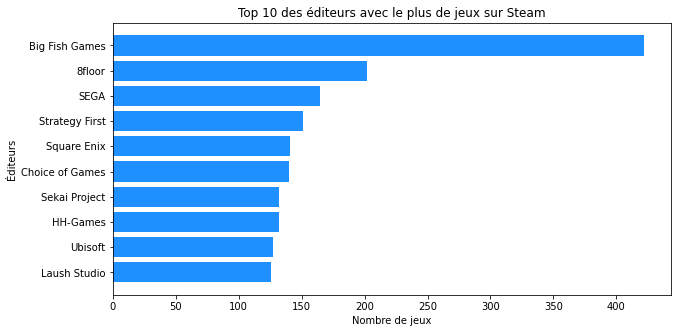

In [0]:
df_pub = df.filter(col("publisher").isNotNull()) \
           .groupBy("publisher") \
           .count() \
           .orderBy(col("count").desc()) \
           .limit(10)

pd_df = df_pub.toPandas()

# Vérification rapide
print(pd_df.head())

plt.figure(figsize=(10, 5))
plt.barh(pd_df["publisher"], pd_df["count"], color="dodgerblue")
plt.xlabel("Nombre de jeux")
plt.ylabel("Éditeurs")
plt.title("Top 10 des éditeurs avec le plus de jeux sur Steam")
plt.gca().invert_yaxis()
plt.show()


🔸 2. Jeux les mieux notés

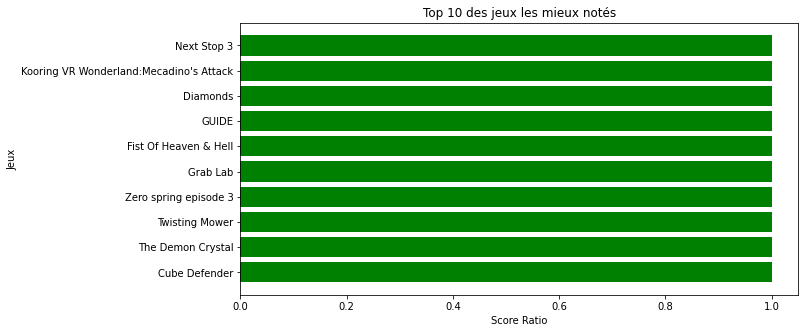

In [0]:
df_score = df.withColumn("score_ratio", col("positive") / (col("positive") + col("negative")))
df_score = df_score.select("name", "score_ratio").orderBy(col("score_ratio").desc()).limit(10)

pd_df = df_score.toPandas()
plt.figure(figsize=(10, 5))
plt.barh(pd_df["name"], pd_df["score_ratio"], color="green")
plt.xlabel("Score Ratio")
plt.ylabel("Jeux")
plt.title("Top 10 des jeux les mieux notés")
plt.gca().invert_yaxis()
plt.show()


🔸 3. Nombre de jeux publiés par année

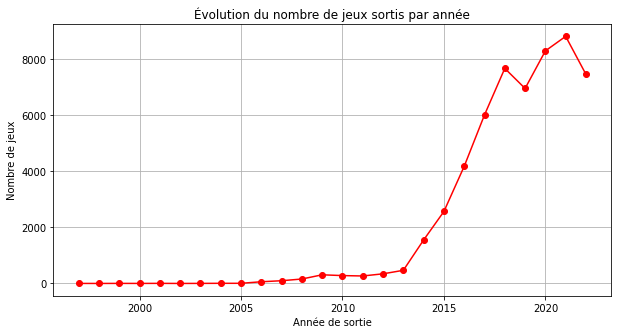

In [0]:
df_year = df.groupBy("release_year").count().orderBy(col("release_year"))
pd_df = df_year.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(pd_df["release_year"], pd_df["count"], marker="o", linestyle="-", color="red")
plt.xlabel("Année de sortie")
plt.ylabel("Nombre de jeux")
plt.title("Évolution du nombre de jeux sortis par année")
plt.grid()
plt.show()


🔸 4. Impact du COVID sur les sorties (2018-2022)

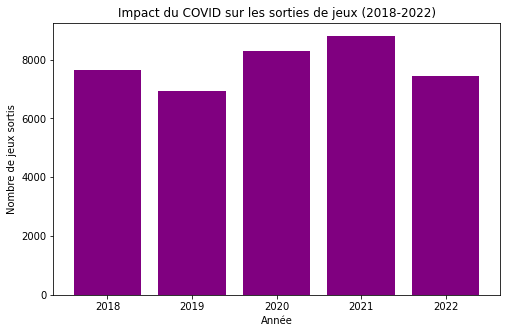

In [0]:
df_covid = df.filter((col("release_year") >= 2018) & (col("release_year") <= 2022))
df_covid = df_covid.groupBy("release_year").count().orderBy(col("release_year"))

pd_df = df_covid.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(pd_df["release_year"], pd_df["count"], color="purple")
plt.xlabel("Année")
plt.ylabel("Nombre de jeux sortis")
plt.title("Impact du COVID sur les sorties de jeux (2018-2022)")
plt.show()


🔸 5. Distribution des prix et des réductions

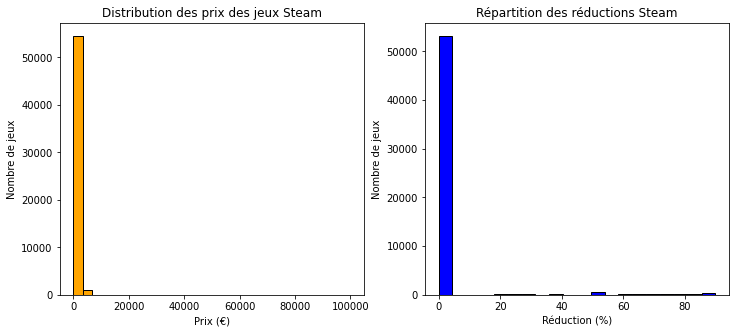

In [0]:
df_price = df.select("price", "discount").toPandas()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_price["price"], bins=30, color="orange", edgecolor="black")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de jeux")
plt.title("Distribution des prix des jeux Steam")

plt.subplot(1, 2, 2)
plt.hist(df_price["discount"], bins=20, color="blue", edgecolor="black")
plt.xlabel("Réduction (%)")
plt.ylabel("Nombre de jeux")
plt.title("Répartition des réductions Steam")
plt.show()


🔸 6. Langues les plus représentées

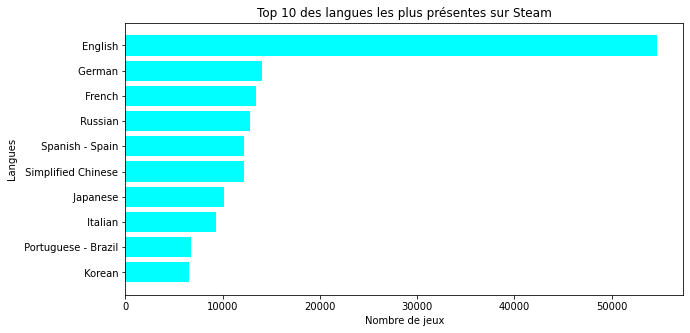

In [0]:
df_lang = df.select(explode(split(col("languages"), ","))).groupBy("col").count().orderBy(col("count").desc()).limit(10)
pd_df = df_lang.toPandas()

plt.figure(figsize=(10, 5))
plt.barh(pd_df["col"], pd_df["count"], color="cyan")
plt.xlabel("Nombre de jeux")
plt.ylabel("Langues")
plt.title("Top 10 des langues les plus présentes sur Steam")
plt.gca().invert_yaxis()
plt.show()


📊 3.2 Analyse des Genres

🔸 7. Genres les plus populaires

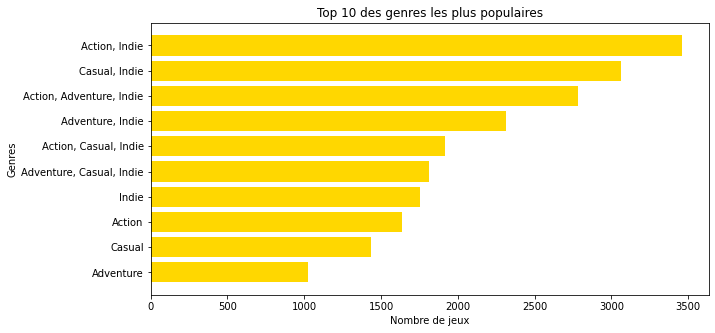

In [0]:
df_genre = df.groupBy("genre").count().orderBy(col("count").desc()).limit(10)
pd_df = df_genre.toPandas()

plt.figure(figsize=(10, 5))
plt.barh(pd_df["genre"], pd_df["count"], color="gold")
plt.xlabel("Nombre de jeux")
plt.ylabel("Genres")
plt.title("Top 10 des genres les plus populaires")
plt.gca().invert_yaxis()
plt.show()


🔸 8. Ratio critiques positives/négatives par genre

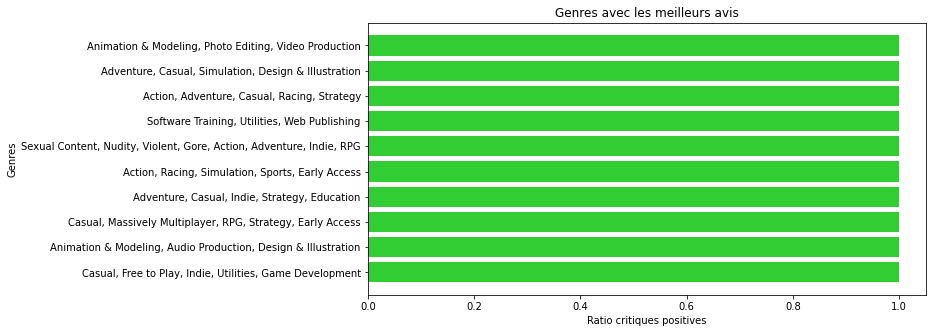

In [0]:
df_ratio = df.groupBy("genre").agg(avg(col("positive") / (col("positive") + col("negative"))).alias("positive_ratio"))
df_ratio = df_ratio.orderBy(col("positive_ratio").desc()).limit(10)

pd_df = df_ratio.toPandas()
plt.figure(figsize=(10, 5))
plt.barh(pd_df["genre"], pd_df["positive_ratio"], color="limegreen")
plt.xlabel("Ratio critiques positives")
plt.ylabel("Genres")
plt.title("Genres avec les meilleurs avis")
plt.gca().invert_yaxis()
plt.show()


📊 3.3 Analyse des Plateformes

🔸 9. Disponibilité des jeux par plateforme

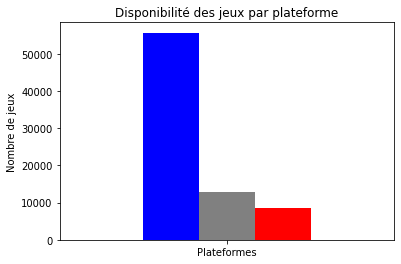

In [0]:
df_platforms = df.select(
    count(when(col("windows") == True, 1)).alias("Windows"),
    count(when(col("mac") == True, 1)).alias("Mac"),
    count(when(col("linux") == True, 1)).alias("Linux")
).toPandas()

df_platforms.plot(kind="bar", legend=False, color=["blue", "grey", "red"])
plt.xticks(ticks=[0], labels=["Plateformes"], rotation=0)
plt.ylabel("Nombre de jeux")
plt.title("Disponibilité des jeux par plateforme")
plt.show()


✅ 4. Conclusion et Finalisation

In [0]:
print("🎯 ANALYSE TERMINÉE ! 🚀")


🎯 ANALYSE TERMINÉE ! 🚀
